Initially 2274 rows.
596 rows have missing EDSS values and will be dropped...


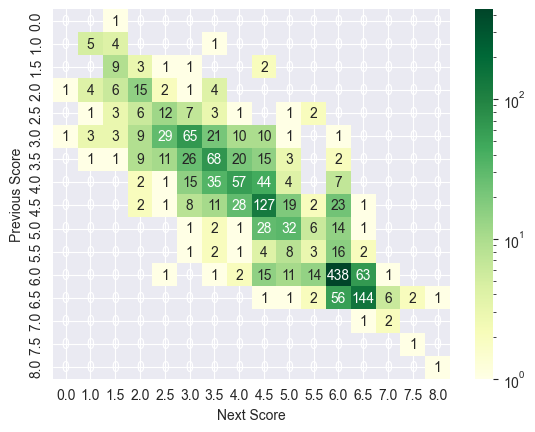

886 rows have a previous EDSS > 5 and will be dropped...
43 rows have missing DMOs and will be dropped...
We have 63 transitions across 58 subjects, out of a total of 749 valid samples.


,Local.Participant,visit.number,EDFSCR1L,Prev_EDSS,Prev_Timepoint,progression,wb_all_sum_w,walkdur_all_sum_w,wbsteps_all_sum_w,wbdur_all_avg_w,...,ws_30_avg_w,strlen_30_avg_w,cadence_30_avg_w,strdur_30_avg_w,ws_30_p90_w,cadence_30_p90_w,ws_30_var_w,strlen_30_var_w,wb_60_sum_w,n_days_w
29,10382,T2,6.0,4.0,T1,1,340.0,74.0,6773.0,8.4,...,0.84,106.0,94.0,1.25,1.00,103.0,17.0,16.0,7.0,7.0
46,10385,T4,6.0,4.5,T3,1,141.0,54.0,4949.0,10.9,...,0.96,116.0,98.0,1.16,1.12,109.0,18.0,14.0,10.0,7.0
74,10393,T2,5.0,4.0,T1,1,491.0,97.0,7743.0,8.2,...,0.83,118.0,84.0,1.35,1.03,98.0,19.0,13.0,3.0,7.0
77,10393,T5,6.0,4.5,T4,1,395.0,82.0,6761.0,8.5,...,0.86,120.0,84.0,1.34,1.07,100.0,19.0,11.0,4.0,7.0
213,21138,T3,5.0,3.0,T2,1,216.0,39.0,3362.0,7.8,...,0.83,111.0,88.0,1.28,0.97,95.0,19.0,14.0,2.0,7.0


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import os
from dotenv import load_dotenv
from prometheus_client.decorator import n_args

load_dotenv()

data_dir = os.getenv("DATA_DIR", "Dataset")

# read in main MS dataset
label_file_path = data_dir + r"MS_dataset_v.7.3.csv"
labels_df = pd.read_csv(label_file_path, usecols=['Local.Participant', 'EDFSCR1L', 'visit.number'])

# Crop down to just the necessary columns
labels_df = labels_df.sort_values(by=['Local.Participant', 'visit.number'])

# shift timepoints and EDSS to get previous as columns
labels_df['Prev_EDSS'] = labels_df.groupby('Local.Participant')['EDFSCR1L'].shift(1)
labels_df['Prev_Timepoint'] = labels_df.groupby('Local.Participant')['visit.number'].shift(1)

# get progression label column
progression_mask = (labels_df['Prev_EDSS'] < 5.0) & (labels_df['EDFSCR1L'] >= 5.0)
labels_df['progression'] = np.where(progression_mask, 1, 0)

transitions = labels_df[progression_mask]  # all the data where a transition happens, just in case.

labels_df['Prev_Timepoint'] = labels_df['Prev_Timepoint'].str.upper()  # needed for later merges
labels_df['visit.number'] = labels_df['visit.number'].str.upper()  # this one is just for consistency

#display(transitions.head(10))

# now that we have a reduced dataset, loop through our weekly dmo aggregations and append the relevant ones to the dataframe
timepoints = ["T1", "T2", "T3", "T4"]  # we don't need DMOs where T5 is previous

dfs_list = []
for timepoint in timepoints:
    feature_file_path = data_dir + f"/{timepoint} Aggregated DMO Data_V7.3/cvs-{timepoint}-weekly_agg_all-21-01-2026.csv"
    temp_df = pd.read_csv(feature_file_path)
    dfs_list.append(temp_df)

features_df = pd.concat(dfs_list, ignore_index=True)
labels_df = pd.merge(labels_df, features_df, left_on=['Local.Participant', 'Prev_Timepoint'],
                     right_on=['participant_id', 'visit_type'], how='left')

labels_df = labels_df.drop(['participant_id', 'visit_type'], axis=1)
labels_df = labels_df.dropna(subset=['Prev_Timepoint'])

# Data cleaning - will monitor number of rows throughout
print(f"Initially {len(labels_df)} rows.")

# get rid of participants where either current or previous EDSS is missing
count_before = len(labels_df)
labels_df = labels_df.dropna(subset=['EDFSCR1L', 'Prev_EDSS'])
print(f"{count_before - len(labels_df)} rows have missing EDSS values and will be dropped...")

# Create matrix of prev -> next EDSS scores
prev_scores = labels_df['Prev_EDSS'].to_numpy().tolist()
next_scores = labels_df['EDFSCR1L'].to_numpy().tolist()

# extract the unique scores
scores = list(set(prev_scores).union(set(next_scores)))
scores.sort()
n_scores = len(scores)

# Create transition matrix
transition_matrix = pd.DataFrame(
    np.zeros((n_scores, n_scores),dtype=int),
    index=scores,
    columns=scores)

for prev_score, next_score in zip(prev_scores ,next_scores):
    transition_matrix.loc[prev_score, next_score] += 1

# Pretty print transition matrix as heatmap
ax = plt.subplot()
sns.heatmap(transition_matrix.values, annot=True, cmap="YlGn", ax=ax, fmt='g', norm=colors.LogNorm())
ax.set_xlabel('Next Score')
ax.set_ylabel('Previous Score')
ax.xaxis.set_ticklabels(scores)
ax.yaxis.set_ticklabels(scores)
plt.show()

# get rid of participants with Prev_EDSS > 5 as predicting these is not useful and will mess up our DMO thresholds that the algorithms may learn:
count_before = len(labels_df)
high_prev_edss_mask = (labels_df['Prev_EDSS'] >= 5.0)
print(f"{sum(high_prev_edss_mask)} rows have a previous EDSS > 5 and will be dropped...")
labels_df = labels_df.drop(labels_df[high_prev_edss_mask].index)

# drop all remaining NAN rows, which will be due to missing DMOs
count_before = len(labels_df)
labels_df = labels_df.dropna()
print(f"{count_before - len(labels_df)} rows have missing DMOs and will be dropped...")

num_progressions = len(labels_df[labels_df["progression"] == 1])
unique_sub_progressions = len(labels_df[labels_df["progression"] == 1]['Local.Participant'].unique())

print(
    f"We have {num_progressions} progressions across {unique_sub_progressions} subjects, out of a total of {len(labels_df)} valid samples.")

display(labels_df[labels_df["progression"] == 1].head(5))

labels_df.to_csv("data.csv", index=False)

# need to be at least 1 (not 0.5) to change
# subset of EDSS and normalise?
# balance dataset - Done very good

undersampled_df = labels_df.groupby('progression').sample(labels_df.groupby('progression').size().min())

cadence_30_p90_w     0.522586
cadence_30_avg_w     0.519007
ws_30_p90_w          0.455805
ws_30_avg_w          0.450679
wbdur_all_var_w      0.397746
strdur_30_avg_w      0.394507
cadence_all_avg_w    0.377722
ws_10_p90_w          0.363808
ws_1030_avg_w        0.345512
strdur_all_var_w     0.216110
strlen_30_avg_w      0.212335
wbsteps_all_sum_w    0.207646
wbdur_all_avg_w      0.171467
strdur_all_avg_w     0.167855
n_days_w             0.147271
dtype: float64

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

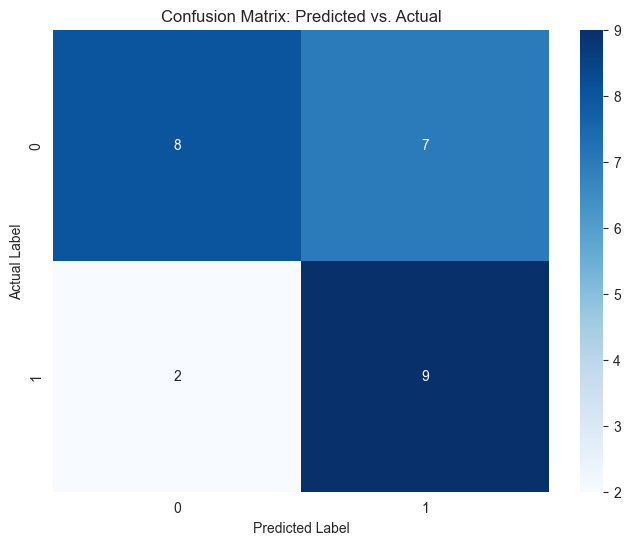

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

KeyboardInterrupt: 

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt
import seaborn as sns

# drop irrelevant or 'cheating' columns
labels_y = undersampled_df["progression"].reset_index(drop=True)
labels_X = undersampled_df.drop(["progression", "Local.Participant", "EDFSCR1L",
                                 "visit.number", "Prev_EDSS", "Prev_Timepoint"], axis=1).reset_index(drop=True)

# feature importance analysis
pearson_corr = labels_X.corrwith(labels_y).abs().sort_values(ascending=False).iloc[0:15]

display(pearson_corr)

# train test split
X_train, X_test, y_train, y_test = train_test_split(labels_X, labels_y, test_size=0.2, random_state=42)

# normalisation
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# sample weighting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']),  # Type of kernel
        'degree': Integer(1, 5)  # Degree for poly kernel
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train, sample_weight=sample_weights)

# Print the best parameters
print(f"Best Parameters: {model.best_params_}")
print(f"Best Score: {model.best_score_}")

# evaluate
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix: Predicted vs. Actual')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Run 5-fold cross-validation

# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', model)
])

scores = cross_val_score(pipeline, labels_X, labels_y, cv=5, scoring='accuracy')
print(scores)
print('Model accuracy score : {0:0.4f}'.format(scores.mean()))

# Visualisation od the results in confusion matrix
# Annoyingly cross_val_score and cross_val_predict can differ ???

y_pred = cross_val_predict(pipeline, labels_X, labels_y, cv=5)
conf_mat = confusion_matrix(labels_y, y_pred)

# Pretty print confusion matrix

ax = plt.subplot()

confusion_matrix = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGn", ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()